In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 

In [2]:
#Read main data to DataFrame
cleaned_df = pd.read_csv('processed_data/cleaned_df.csv', index_col=0)  

In [3]:
df_original = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

df_out=df_original[["a5sscore_i_06","a6smemory_p1_06","a6smemory_p2_06","a7a_delay_06","a7b_delay_06",
        "a7c_delay_06","a7d_delay_06","a9sgrossmotor_06","height_06","weight_06","z_tvip_06","z_social_06",
        "z_language_06","z_finmotor_06","z_memory_06","z_grmotor_06","z_legmotor_06","z_behavior_06","z_height_06",
        "z_weight_06","z_all_06"]]

In [4]:
cleaned_df.drop(cleaned_df[df_out.iloc[cleaned_df.index].z_all_06.isna()].index, axis=0, inplace=True)

In [15]:
cleaned_df["z_all_06"]=df_out.iloc[cleaned_df.index].z_all_06

In [16]:
cp_cols=["hogarid_old"]

In [17]:
cleaned_df.drop(cp_cols, axis=1, inplace=True)

In [18]:
def outlier_removal(df, cols):
    outlier_threshold = []
    for col in cols:
            q3 = np.nanpercentile(df[col], 75)
            q1 = np.nanpercentile(df[col], 25)
            iqr = q3 - q1
            out_low = q1 - 3*iqr
            out_high = q3 + 3*iqr
            outlier_threshold.append([out_low, out_high])
    outliers_indexs=[]
    for col,k in zip(cols,range(len(cols))):
        #outliers_indexs_in_col=[]
        for i in df[col].index:
            if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
                outliers_indexs.append(i)
        #outliers_indexs.append(outliers_indexs_in_col)
    return df.drop(list(set(outliers_indexs)), axis=0)

cleaned_df=outlier_removal(cleaned_df, ["z_all_06"])

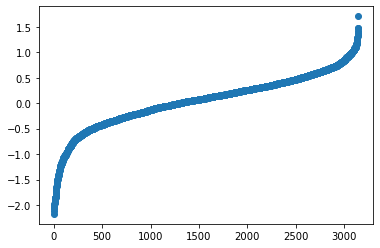

In [19]:
plt.scatter([i for i in range(len(cleaned_df["z_all_06"].sort_values().values))], cleaned_df["z_all_06"].sort_values().values)

(array([ 22.,  29.,  72., 166., 517., 921., 907., 409.,  96.,   6.]),
 array([-2.1753304 , -1.7871083 , -1.3988862 , -1.0106641 , -0.62244195,
        -0.23421985,  0.15400226,  0.54222435,  0.9304465 ,  1.3186686 ,
         1.7068907 ], dtype=float32),
 <BarContainer object of 10 artists>)

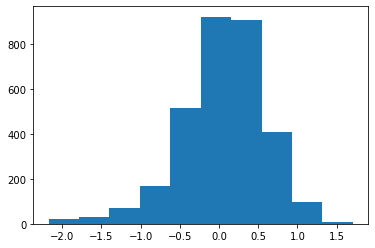

In [20]:
plt.hist(cleaned_df["z_all_06"])

In [21]:
cleaned_df["zall06_cat"] = pd.cut(cleaned_df["z_all_06"],
                               bins=[-np.inf, -0.75, -0.25, 0.25, 0.75, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [22]:
cleaned_df["zall06_cat"].value_counts().sort_values()

1     204
5     212
2     574
4     962
3    1193
Name: zall06_cat, dtype: int64

In [14]:
treatment = 'tr'
outcome = 'z_all_06'
covariates = list(cleaned_df.columns)
covariates.remove(treatment)
covariates.remove(outcome)
covariates.remove("zall06_cat")

In [15]:
cleaned_df.z_all_06.values

array([ 0.45015588,  0.01125175, -0.5053326 , ...,  0.43954134,
        0.03532236, -0.03708899], dtype=float32)

In [70]:
from sklearn.model_selection import train_test_split
# split data into train and test sets 
train, test = train_test_split(cleaned_df, stratify=cleaned_df.zall06_cat, test_size=0.2, random_state=0)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
y_train = train[outcome]
X_train = train[covariates+["tr"]]
X_train_all=train[covariates+["tr"]+[outcome]]

X_test = test[covariates+["tr"]]
y_test =  test[outcome]
X_test_all=test[covariates+["tr"]+[outcome]]

In [17]:
def display_scores(scores,model_name = None):
    if(model_name):
        print("----",model_name,"----")
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [681]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

lightgbm = lgb.LGBMRegressor()
lightgbm.fit(X_train,y_train)

 
    # lets comare all of them 
models = [(lin_reg,"lin_reg"),
          (forest_reg,'Random Forest'),
          (xg_reg,"XGboost")]
for model in models:
    scores = cross_val_score(model[0], X_test, y_test, scoring='r2', cv=10)
    display_scores(scores, model[1])
    scores = cross_val_score(model[0], X_test, y_test, scoring='neg_root_mean_squared_error', cv=10)
    display_scores(-scores, model[1])

---- lin_reg ----
Mean: 0.1749333502098888
Standard deviation: 0.1299303829565213
---- lin_reg ----
Mean: 0.46466063792293644
Standard deviation: 0.03697566347138594
---- Random Forest ----
Mean: 0.275131257083054
Standard deviation: 0.08918137389371394
---- Random Forest ----
Mean: 0.4368676100624608
Standard deviation: 0.04061713431103447
---- XGboost ----
Mean: 0.2223000572667897
Standard deviation: 0.11736677113939557
---- XGboost ----
Mean: 0.4511720359325409
Standard deviation: 0.04029210042367663


In [661]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(clf, X_train, y_train, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=3,
        scoring="neg_root_mean_squared_error",
        train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    )

    train_mean = -train_scores.mean(axis=1)
    test_mean = -test_scores.mean(axis=1)

    plt.subplots(figsize=(5,4))
    plt.plot(train_sizes, train_mean, label="train")
    plt.plot(train_sizes, test_mean, label="validation")
    #plt.ylim(0,0.55)

    plt.title("Learning Curve"+title)
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend(loc="best")

    plt.show()

In [72]:
import lightgbm as lgb

In [73]:
best_lightgbm =lgb.LGBMRegressor(application='regression_l2', boosting_type='gbdt', 
                                  colsample_bytree=0.3004571253236143, extra_trees=True, 
                                  learning_rate= 0.07116177177396639, max_depth= 164,
                                  min_child_weight= 0.00850418085429701, min_split_gain= 0.08258787964701664,
                                  n_estimators=353, num_leaves= 101, reg_alpha= 0.006378130018392472,
                                  reg_lambda=0.006971035283303719, subsample= 0.9530989839136036,
                                  subsample_for_bin= 819, subsample_freq= 6)

In [74]:
best_lightgbm.fit(X_train, y_train)
counterfactual=best_lightgbm.predict(counterfactual_df)

In [75]:
len(X_train_full.columns)

46

In [76]:
len(X_train.columns)

46

In [77]:
X_train_full=cleaned_df.drop(["z_all_06", "zall06_cat"], axis=1)
y_train_full=cleaned_df.z_all_06

In [78]:
feature_importances=pd.Series(best_lightgbm.feature_importances_, index=X_train.columns).sort_values()

<AxesSubplot:>

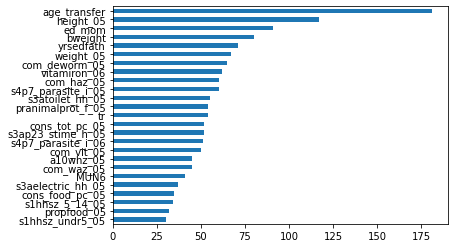

In [79]:
feature_importances[-25:].plot(kind='barh')

In [82]:
observed=cleaned_df["z_all_06"]
counterfactuals=pd.Series(counterfactual, index=observed.index)

In [83]:
ite_temp=pd.Series([observed[i]-counterfactuals[i] for i in observed.index if cleaned_df.tr[i]==1]
                   , index=cleaned_df[cleaned_df.tr==1].index)
ite_temp1=pd.Series([counterfactuals[i]-observed[i] for i in observed.index if cleaned_df.tr[i]==0]
                    , index=cleaned_df[cleaned_df.tr==0].index)
ite=pd.concat([ite_temp,ite_temp1])
ite.sort_index(inplace=True)

In [84]:
ite

1       0.491251
2      -0.203480
3      -0.480164
4      -0.376093
6       0.194360
          ...   
3544    0.170264
3545   -0.245288
3546   -0.229480
3547   -0.017525
3548   -0.365705
Length: 3145, dtype: float64

In [85]:
def ate(X):

    return np.mean(X[X.tr==1].z_all_06)-np.mean(X[X.tr==0].z_all_06)

In [86]:
ate(cleaned_df)

0.03728927858173847

In [87]:
ate(X_train_all)

0.0425249096006155

In [97]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test, best_lightgbm.predict(X_test)))

0.42410761562863925

In [88]:
ite.describe()

count    3145.000000
mean        0.000122
std         0.433429
min        -2.234243
25%        -0.228847
50%         0.021152
75%         0.263642
max         2.080972
dtype: float64

<AxesSubplot:ylabel='Count'>

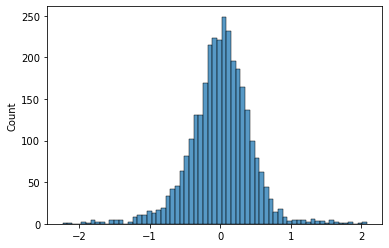

In [100]:
import seaborn as sb

sb.histplot(ite)

In [101]:
ite_df=counterfactual_df.copy()
ite_df["ite"]=ite

In [102]:
ite_in=ite_df[['propfood_05', 'height_05', 'com_vit_05', 'com_waz_05',
       'com_deworm_05']]

In [103]:
from sklearn.tree import DecisionTreeRegressor
import graphviz
import os 

dec_tree= DecisionTreeRegressor() 
dec_tree.fit(ite_in, ite_df)

DecisionTreeRegressor()

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz/bin/'
# DOT data
dot_data = sklearn.tree.export_graphviz(dec_tree, out_file=None, 
                                feature_names=['propfood_05', 'height_05', 'com_vit_05', 'com_waz_05','com_deworm_05']) 
                                
graph = graphviz.Source(dot_data, format="pdf") 
graph.render("ite_sbgp", format="pdf", view=False)